<a href="https://colab.research.google.com/github/nafroze/Deep_Learn/blob/main/Basic_CNN_DEMO_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Deep Learning: AGB Estimation using PyTorch and Satellite Imagery

Welcome to this tutorial on leveraging PyTorch for satellite imagery analysis. Our primary objective is to train a Convolutional Neural Network (CNN) to estimate Aboveground Biomass (AGB) using the Landsat satellite imagery and digital elevation model (DEM) data.

This tutorial will cover the following topics:

* Downloading the demonstration dataset
* Configuring the Colab environment
* Introduction to PyTorch tensors
* PyTorch Datasets and understanding their role in fitting models
* Working with PyTorch DataLoaders
* Designing and understanding the architecture of a PyTorch CNN
* Getting acquainted with the basic PyTorch training loop
* Visualizing and interpreting model predictions to assess the performance and accuracy of our model.
* Examining internal feature representation to gain insights into how our neural network processes and perceives information.

Let's dive in and uncover the potential of PyTorch for deep learning in the realm of satellite imagery analysis!

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# Configuring Colab

In this section we will cover:

1.   How to enable GPU usage in Colab
2.   Installing PyTorch and other packages using Python's pip
3.   Importing the relevant Python libraries
4.   Configure Google Drive access in Colab
5.   Downloading the dataset from Google Drive to Colab
6.   Introduce the notion of devices in PyTorch



## Enabling GPU Utilization

No additional code is required for this step!

To utilize the GPU capabilities provided by Google Colab, navigate to the toolbar and select the *Runtime* option located at the top left-hand side of the Colab notebook. From the drop-down menu, choose *Change runtime type*.

Ensure that the drop-down menu for the hardware accelerator is set to "GPU". This action will allocate a GPU to the runtime instance. While the provided GPU may not offer top-of-the-line performance, it is still notably advantageous. The utilization of even a relatively modest GPU can potentially provide a 10-50x runtime speedup compared to using a CPU for training a neural network.

By enabling the GPU option, you are ensuring that you make the most out of the resources available, leading to more efficient and quicker data processing and model training.

## Installing PyTorch & other packages

These days, PyTorch seems to work out of the box on Colab!

If you are working on your own machine, you can copy and paste the appropriate installation command for your specific machine from the "[Starting Locally](https://pytorch.org/get-started/locally/)" section on the PyTorch website.

It is **strongly** recommended that you use virtual environments when working locally. If you start messing with CUDA in your base Python enviornment, you will have a miserable time once it breaks.  

If you intend to work in Colab in a more substantial manner, I would read the "[Running Tutorials in Google Colab](https://docs.pytorch.org/tutorials/beginner/colab.html)" article for more information. However, given the compute resources available at Oregon State University, this would be a... questionable... decision.


In [1]:
!pip3 install torchinfo

In [17]:
!ndivia-smi

/bin/bash: line 1: ndivia-smi: command not found


## Import all of the relevant libraries

Next, we will import all of the relevant libraries that we will need. This is basically the exact same thing as R -- these are pre-written packages of code we are loading in to use later.

Specifically, we verify the installation of the following packages:

* **torch (PyTorch)**: PyTorch is an open-source machine learning library based on the Torch library, designed for both research prototyping and production deployment. It provides a wide range of functionalities for deep learning, and supports Tensor computation with GPU acceleration.

* **torchvision**: Torchvision is a PyTorch add-on library that provides useful datasets, pre-trained models, and transformation functions specifically designed for computer vision tasks. It simplifies the process of building and training vision-based models.

* **torchinfo**: Torchinfo is a PyTorch utility that provides a detailed layer-by-layer printout of a PyTorch model, similar to Keras's model.summary() function. It helps in understanding the architecture of the model, including the shape and number of parameters at each layer.

* **tqdm**: Tqdm is a fast, extensible progress bar library for Python that can be wrapped around any iterable or executed as a module. It can help visualize the progress of loops or other time-consuming operations.

* **gdal (Geospatial Data Abstraction Library)**: GDAL is a translator library for raster and vector geospatial data formats that presents a single raster abstract data model and a single vector abstract data model to the calling application.

In [2]:
# These are for the tutorial
import numpy as np
import shutil
import shutil
import zipfile
import random
from glob import glob

# Neural network functions
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# For rendering printouts of the network
from torchinfo import summary

# Making pretty status bars
from tqdm.notebook import tqdm

# Rendering figures
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

# Lots of useful torch-related functions
import torchvision.datasets as datasets

# Needed to mount Google Drive and get access for data
from google.colab import drive

# Used for manipulating raster data
from osgeo import gdal

## Setting the computational device

Often, if I am using base PyTorch, it is helpful to define a global variable called DEVICE that indicates where PyTorch tensors should be stored for computation.

Using the PyTorch method `.to()` you can send a PyTorch Tensor object to a particular device for computer. Options include things like: GPUs (Graphics Processing Units), TPUs (Tensor Processing Units), CPU (Central Processing Units), etc. This is import as computation using PyTorch Tensors requires that all tensors/models be stored on the same device. Have the global variable can make swaping between CPU/GPU for debugging easier than manually channing each `.to()` call.

In [3]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


It is important to note that you cannot perform computations with tensors that are stored on different devices. This is important as your data loader, for example, might be loading saved NumPy arrays into memory. These loaded arrays must be moved to the same device as the model.

The code below will raise a *RuntimeError* as tensor *a* is set to the CPU and tensor *b* is stored on the GPU (specifically device 0... if you had 2 GPUs you would have two devices: *cuda:0* and *cuda:1*.

In [6]:
a = torch.rand(10,10).to("cpu")
b = torch.rand(10,10).to("cuda")
a + b

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

If we move the two tensors to the same device, everything is beautiful.

In [7]:
a = torch.rand(10,10).to("cuda")
b = torch.rand(10,10).to("cuda")
a + b

tensor([[0.9101, 1.1062, 1.2504, 1.0569, 1.5396, 1.3082, 0.3881, 0.9799, 0.1686,
         1.4909],
        [1.0576, 1.3306, 0.8003, 0.9698, 0.4282, 1.1010, 1.6198, 0.6611, 1.1268,
         1.0134],
        [0.6059, 1.3999, 1.0873, 1.3068, 0.8792, 0.3009, 0.7116, 1.2761, 0.8010,
         0.7934],
        [0.8163, 0.7561, 0.0748, 0.6387, 1.2002, 0.4153, 0.1577, 0.9273, 0.7734,
         0.3274],
        [0.6736, 1.3562, 0.6665, 0.6075, 1.0217, 1.0499, 0.7117, 1.2097, 0.8661,
         0.8938],
        [0.7224, 0.9511, 0.7821, 0.4116, 1.2730, 0.7853, 1.2463, 1.1196, 0.6174,
         1.0914],
        [1.1446, 1.0693, 1.0810, 0.4477, 1.2424, 1.6603, 0.8391, 1.0099, 0.9417,
         1.0356],
        [1.6897, 1.7341, 1.4610, 1.6607, 0.9333, 1.3917, 0.6596, 1.3042, 0.3490,
         0.9147],
        [0.8652, 1.4401, 0.9399, 0.3369, 0.9678, 0.4170, 1.3926, 1.3109, 0.8511,
         0.5488],
        [1.2678, 1.3989, 1.0543, 1.5142, 1.1330, 1.6435, 0.4188, 1.0959, 0.8535,
         0.3819]], device='c

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# Configuring Google Drive & downloading the modeling dataset

In this section we will do the following:

1.   Formatting a folder for this exercise in your Google Drive
2.   Downloading the datasets required for this exercise
3.   Mount Google Drive as a virtual drive in Colab
4.   Transferring the dataset and unpacking it in Colab

## Setting up a folder to hold data

Navigate to your Google Drive folder and create a folder in your google drive called **EMAPR_PyTorch_Demo**.

Then, inside of the **EMAPR_PyTorch_Demo** create two sub directories: **train** and **test**.

We wil use this folder to store the training and testing datasets used in our experiements here as well as a small raster dataset from which we can perform inference with our trained model.

Eventually, we will also save the model wights inside of that folder

## Download the dataset from the host drive

I am hosting the datasets in a folder in my Google Drive. You can download the 3 datasets using these links:

1.   [oregon_subset_2022.tif](https://drive.google.com/file/d/1--yRln0kJ_Fql3RkPmWSpP5Yg31bwQsE/view?usp=sharing)
2.   [train.zip](https://drive.google.com/file/d/1WUBhTU17hSou6Fy6KNQPQ3iVMZ_bNpK9/view?usp=sharing)
2.   [test.zip](https://drive.google.com/file/d/1_6H_oEdPl7Jl1wZLDnbwuCHYNAWCPwWv/view?usp=sharing)

These are, respectively, a GeoTIFF which we will use for inference later. The training dataset, and testing dataset (the latter two are zip files consisting of compressed NumPy arrays).

Please download these files and upload them into your Google Drive folder called: **EMAPR_PyTorch_Demo**.


## Mounting Google Drive

First, we are going to make it so that Colab interfaces with Google Drive.

In deep learning, you typically load a batch of data from your hard drive into memory (if your memory is small) instead of doing so all at once. However, we want to move the training, testing, and inference data from Google Drive into Colab. This is because it takes a long time to access data from Google Drive directly in Colab.

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Transfer/unpack dataset from Google Drive to Colab

We will transfer and unpack the different files.

First, we will copy the 3 datasets over from Google Drive into the Colab drive. Note that this drive is temporary. Therefore, if your runtime disconnects (which happens quickly in the free version) you will need to reload the dataset into your Colab environment.

In [10]:
# Define the Google Drive directory with the datasets
drive_dir = '/content/drive/MyDrive/EMAPR_PyTorch_Demo'
colab_dir = '/content'

# Define the current and desired location for the files
file_paths = [
    (f"{drive_dir}/oregon_subset_2022.tif", f"{colab_dir}/oregon_subset_2022.tif"),
    (f"{drive_dir}/train.zip", f"{colab_dir}/train.zip"),
    (f"{drive_dir}/test.zip", f"{colab_dir}/test.zip")
    ]

# Move the files from Google Drive into Colab
print('Downloading data...')
for (cur_path, target_path) in tqdm(file_paths):
    shutil.copy(cur_path, target_path)
print("...done.\n")

  0%|          | 0/3 [00:00<?, ?it/s]

...done.



In [11]:
# Unzip the datasets
print("Unzipping datasets...")
with zipfile.ZipFile(f"{colab_dir}/train.zip", 'r') as zip_ref:
    zip_ref.extractall(colab_dir)
with zipfile.ZipFile(f"{colab_dir}/test.zip", 'r') as zip_ref:
    zip_ref.extractall(colab_dir)
print('...done')

Unzipping datasets...
...done


## Visualize a random subset  of examples from the downloaded dataset

We will use *matplotlib* to visualize some of the NumPy arrays we transfered from Google Drive to verify that the data looks like we expect!

Each individual input into the neural network is a 3D matrix with a shape given by *Channels x Rows x Columns*. Here, each example consists of 6 spectral bands captured by the Landsat sensors (blue, green, red, near-rnfrared, shortwave infrared 1 and 2) and a digital elevation model data derived from the USGS 3DEP 10m dataset that was resampled to 30m to match the Landsat data.

The response value (i.e., what we want the neural network to predict) is aboveground biomass (AGB) given in units of megagrams per ha (Mg/ha).

In [12]:
def plot_rgb_time_series_list(
    data_list: list,
    channels: list,
    min_vals: list,
    max_vals: list,
    titles: list,
    dem_array: list,
    stretch_min: float,
    stretch_max: float
    ) -> None:

    # Get the number of time series
    n_time_series = len(data_list)

    # Create a figure with one subplot for each time series (make plots larger)
    fig, axes = plt.subplots(2, n_time_series, figsize=(n_time_series*8, 2*8))

    # Iterate over each time series
    for i, data in enumerate(data_list):

        # Initialize an empty array for the image data
        image_data = np.empty((len(channels), data.shape[1], data.shape[2]), dtype=np.float32)

        # Process each channel
        for k in range(len(channels)):

            # Select the data for this channel
            channel_data = data[channels[k]].astype(np.float32)

            # Clamp and rescale the data
            channel_data = np.clip(channel_data, min_vals[k], max_vals[k])
            channel_data = (channel_data - min_vals[k]) / (max_vals[k] - min_vals[k])

            # Store the processed data
            image_data[k] = channel_data

        # Convert the data to an 8-bit RGB image for visualization
        image_data = (image_data * 255).astype(np.uint8).transpose((1, 2, 0))

        # Plot the image
        axes[1, i].imshow(image_data, interpolation='none') # Only the second row contains the channel data now
        axes[1, i].axis('off')

        # Draw red square around the center pixel with increased linewidth
        center = [(data.shape[1] // 2), (data.shape[2] // 2)]
        rect = plt.Rectangle((center[1] - 0.8, center[0] - 0.8), 1.5, 1.5, edgecolor='r', facecolor='none', linewidth=6)
        axes[1, i].add_patch(rect)

        # Stretch and rescale the DEM array
        dem_image = np.clip(dem_array[i], stretch_min, stretch_max)
        dem_image = (dem_image - stretch_min) / (stretch_max - stretch_min)

        # Convert the DEM data to an 8-bit image for visualization
        dem_image = (dem_image * 255).astype(np.uint8)

        # Plot the DEM array as the first row
        axes[0, i].imshow(dem_image, cmap='viridis', interpolation='none')
        axes[0, i].axis('off')

        # Remove brackets if present, set larger title
        title_clean = str(titles[i]).replace('[', '').replace(']', '')
        axes[0, i].set_title(title_clean + " \n Mg ha$^{-1}$", fontsize=48)

    plt.tight_layout()
    plt.show()

    return None


In [13]:
# Aggregate, shuffle, and select 8 random examples
tensor_paths = glob(f"{colab_dir}/train/*.npz")
random.shuffle(tensor_paths)
tensor_paths = tensor_paths[0:8]

# Load in the different datasets
batch_landsat = []
batch_dem = []
batch_response = []
for path in tensor_paths:
    data = np.load(path)
    landsat = data["features"][0:-1,:,:]
    dem = data["features"][-1,:,:]
    response = data["response"]
    batch_landsat.append(landsat)
    batch_dem.append(dem)
    batch_response.append(response)

# Format the response values as springs
batch_response = [str(x) for x in batch_response]

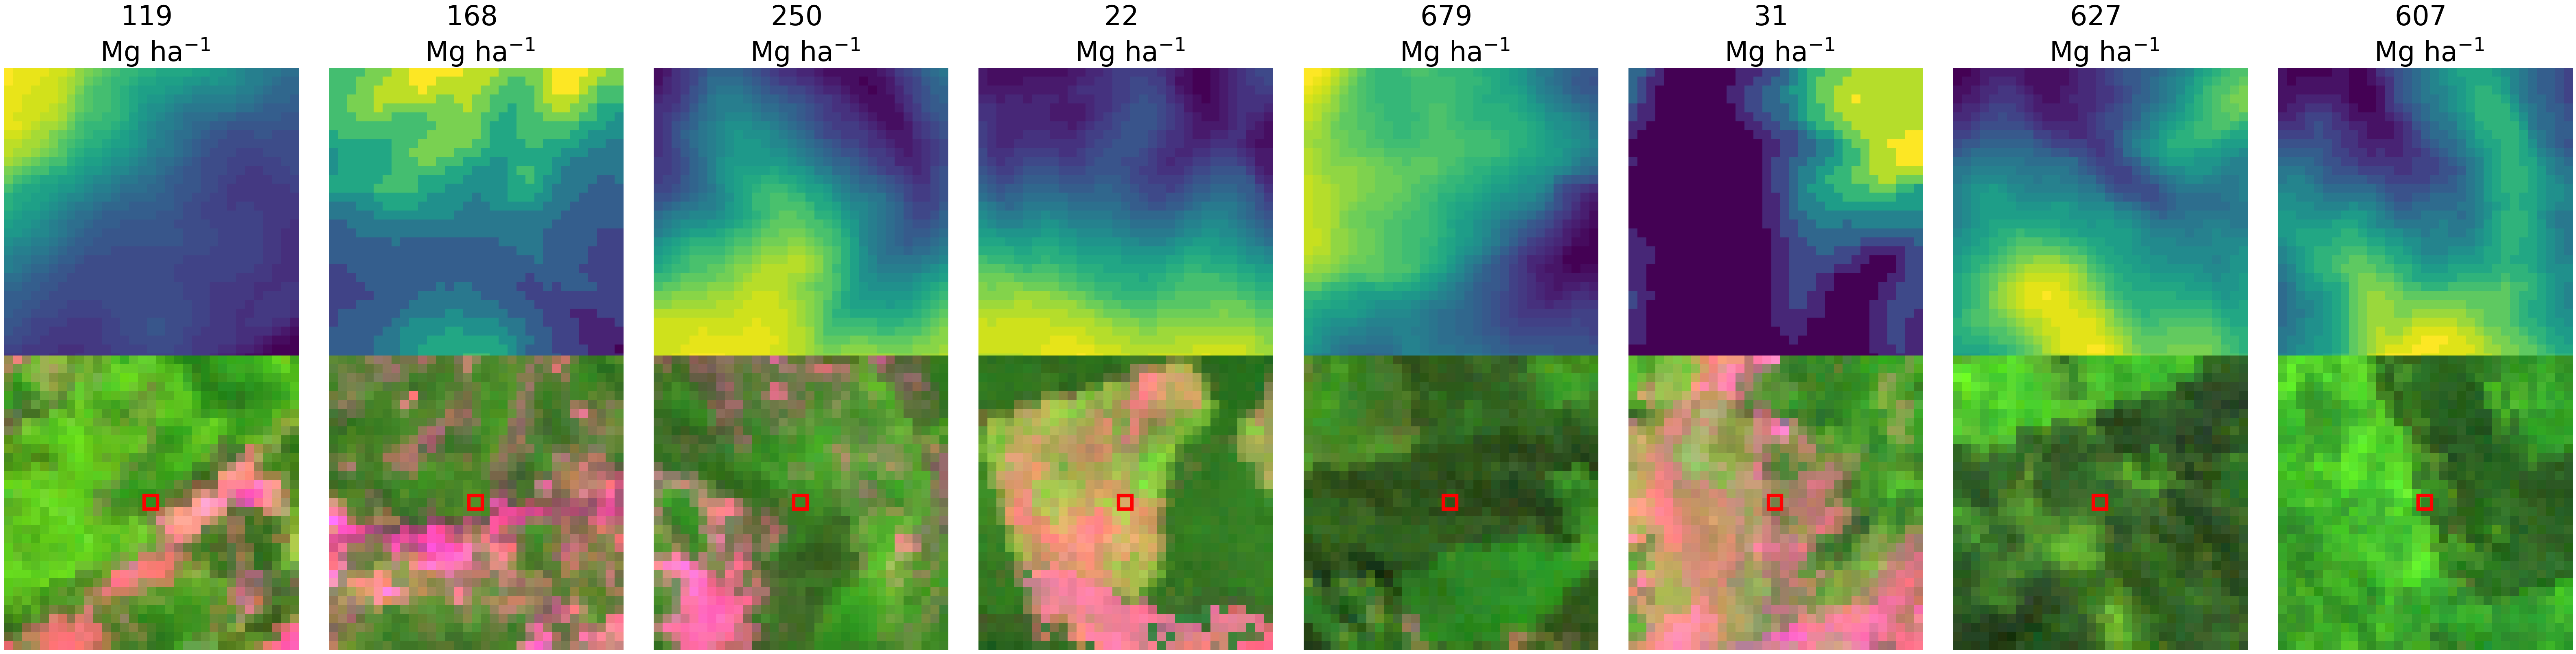

In [14]:
# Visualize the image data (as SWIR B7-B4-B3) and the DEM
plot_rgb_time_series_list(
    data_list = batch_landsat,
    channels = [5,3,2],
    min_vals = [0,0,0],
    max_vals = [1500,5500,1500],
    titles = batch_response,
    dem_array = batch_dem,
    stretch_min = 0,
    stretch_max = 2500
    )

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


# Introduction to PyTorch

PyTorch is very smilar to Numpy in that it gives you the ability to do fun linear algebra stuff like multiple vectors or matrices. However, it adds some secret sauce that makes it useful for deep learning. In particular:


1.   PyTorch tensors (and their opperations) can be run on a Graphics Processing Unit (GPU) which enables opperations to be run very rapidly.
2.   PyTorch performs automatic differentiation.

You can call `__version__` on the PyTorch module to determine which version is installed. This can be very useful for debugging.

In [15]:
print("Using torch", torch.__version__)

Using torch 2.6.0+cu124


Next, we will set a fixed seed value for random number generation. Stochasticity is a key part of deep learning (shuffling the training datset, randomly initalizing the network's parameters, etc.).

This is actually quite important! Consider the problem of hyperparameter tuning. When tuning hyperparameters, you are attempting to identify a combination that yields the greatest increase in model performance. However, changing the random initialization of the weights change model performance as well. If you perform hyperparameter tuning without a fixed seed -- it will not be obvious what is causing the change in model performance -- the initialization or the hyperparameter configuration.

It is worth noting that you need to fix the seed of *multiple* random number generators if you are also using Python's *random* library or NumPy's randomization library.

In [18]:
torch.manual_seed(420)

## Basic commands for manipulating PyTorch Tensors

PyTorch tensors can represent arrays with an arbitrary number of dimensions. They can be manipulated in a similar manner to NumPy arrays. Here, we create an example tensor using the `torch.rand()` function. This function will create tensor with the desired shape with randomly intialized values between 0 and 1.

We then use several several class attributes you can call to retrieve information about the tensor. These include:
*    `.shape`: Which gives the size of each dimension of the array
*    `.dtype`: Which gives the data type of the tensor (e.g., float32)
*    `.device`: Which gives the device the tensor is currently stored on.

In [22]:
# Create a tensor containing random values
x = torch.rand(16, 3, 32, 32)
print("Random 2x2 tensor:")
print(x.shape)


Random 2x2 tensor:
torch.Size([16, 3, 32, 32])


In [23]:
# Print out information about the tensor
print("Tensor shape     : ", x.shape)
print("Tensor data type : ", x.dtype)
print("Tensor device    : ", x.device)


Tensor shape     :  torch.Size([16, 3, 32, 32])
Tensor data type :  torch.float32
Tensor device    :  cpu


As previously noted, you can easily move tensors back and forth between the CPU and the device you are using for fitting the deep learning models (e.g., a TPU or a GPU).

In [24]:
x = x.to(DEVICE)
print("Tensor device    : ", x.device)

x = x.to("cpu")
print("Tensor device    : ", x.device)

Tensor device    :  cuda:0
Tensor device    :  cpu


# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+


# Defining a PyTorch Dataset

When I say a "dataset", going forward, I am specifically refering to
`torch.utils.data.Dataset`, an abstract class, used to build datasets for PyTorch.

### Torch Dataset methods

When creating a PyTorch Dataset, you typically define 3 class methods

*   `__init__` -- as required by all Python classes)
*   `__len__` -- returns the length of the dataset when `len(dataset)` is called
*   `__getitem__` method that retrieves an example from the dataset


### The `__init__` method (required)

This method initalizes the class and accepts 4 arguments: *numpy_dir*, *channel_means*, *channel_stds*, and *in_memory*.

1.   *numpy_dir*: A path to the directory with the NumPy examples
2.   *channel_means*: The average value for the Blue, Green, Red, Near-Infrared, Shortwave Infrared 1 and 2 bands, and the DEM
3.   *channel_stds*: The standard deviation for the Blue, Green, Red, Near-Infrared, Shortwave Infrared 1 and 2 bands, and the DEM
4.   *in_memory*: If true (default), then the entire dataset will be loaded into RAM. This way, the data are fetched from memory instead of from the hard disk which can be a bottleneck during training.

### The `__getitem__` method (required)

This function accepts an index to a given example in the dataset. It will then yeild the features (here a 7x33x33 PyTorch tensor) and a response value (the AGB in Mg Ha).


### The `__len__` method (required)

This simply makes it so that `len(dataset)` yeilds the total number of examples in the dataset. This should usually be defined as some other PyTorch classes will expect classes inheriting from Dataset to have this method defined.

### The `__load_data` method

This method is not require by the data loader. Here, we define it to facilitate with loading examples during the optional data caching proceedure.


In [25]:
import random
import torch
import numpy as np
from glob import glob
from tqdm import tqdm

class LandsatDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, channel_means, channel_stds, in_memory=True, use_rotation=False):

        # Initialize the class attributes
        self.data_dir = data_dir
        self.channel_means = torch.Tensor(channel_means).view(7,1,1)
        self.channel_stds = torch.Tensor(channel_stds).view(7,1,1)
        self.in_memory = in_memory
        self.use_rotation = use_rotation

        # Get the paths to all of the compressed NumPy tensors in the dataset
        self.dataset = glob(self.data_dir + "/*.npz")

        # Load the datasets into memory to avoid
        # read from disk if specified
        if self.in_memory:
            self.data_cache = []
            print('Loading dataset into memory...')
            for idx in tqdm(range(self.__len__()), mininterval=2.5):
                self.data_cache.append(self.__load_data(idx))
            print("...done.")

        return None

    def __getitem__(self, idx):

        # Return the preloaded data if in_memory is True
        if self.in_memory:
            features, response = self.data_cache[idx]
        else:
            features, response = self.__load_data(idx)

        # Normalize the input features
        features = (features - self.channel_means) / self.channel_stds

        # Random rotation augmentation if enabled
        if self.use_rotation:
            # Rotate by 0, 90, 180, or 270 degrees (k=0,1,2,3)
            k = random.randint(0, 3)
            features = torch.rot90(features, k, dims=[1,2])

        return features, response / 1000

    def __len__(self):
        return len(self.dataset)

    def __load_data(self, idx):

        # Load the compressed NPZ file
        x_y_pair = np.load(self.dataset[idx])

        # Unpack and cast
        features = torch.Tensor(x_y_pair["features"])
        response = torch.Tensor(x_y_pair["response"])

        return features, response


In [26]:
# Define the mean and standard deviations
feature_means = [233.5, 420.6, 351.6,	2633.7,	1253.5,	602.2, 658.4]
feature_stds = [132, 174.4, 256.7, 778, 587.7, 441.5, 230.8]

# Load in the dataset
train_dataset = LandsatDataset(f'{colab_dir}/train', feature_means, feature_stds, use_rotation=True)
test_dataset = LandsatDataset(f'{colab_dir}/test', feature_means, feature_stds, use_rotation=False)

Loading dataset into memory...


100%|██████████| 21025/21025 [00:17<00:00, 1230.53it/s]


...done.
Loading dataset into memory...


100%|██████████| 8990/8990 [00:08<00:00, 1115.03it/s]

...done.


In [27]:
x, y = train_dataset.__getitem__(1)
print(x.shape)
print(y.shape)

torch.Size([7, 33, 33])
torch.Size([1])


## Feature Normalization

In the above code, we performed two types of normalization to improve the convergence speed of the neural network.

First, I computed the study area wide mean and standard devication over forested pixels in Oregon. These are used to attempt to normalize the imagery so that each pixel contains values that are approximately zero mean with unit standard deviation. This is important as using the raw 16-bit surface reflectance values can result in very large gradients which can lead to instability during training.

Second, I normalized the response by dividing it by 1000. This is done so that the scale of the the response (in Oregon, the possible values range between 0-1200 Mg/ha) is not greater than that of the normalized inputs. Therefore, when performing inference later, we will need to multiply the network outputs by 1000 to obtain their original range.

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# Defining the DataLoaders

Typically, you do not use PyTorch `Dataset` objects directly to load examples into memory—except perhaps when debugging your training logic. Instead, it is more common to use PyTorch `DataLoader` objects.

Why use a data loader? Consider what happens during training: you randomly select examples from disk (or RAM), move them to the GPU, run the forward and backward passes, and repeat the process. Using a single worker is not particularly efficient. While data is being processed on the GPU, you could be fetching the next batch to keep the GPU fed. Therefore, you usually want *multiple* workers for loading data.

`DataLoader` handles all of this for you. You pass the `Dataset` object to the loader and simply specify the number of workers for data loading.

What is the best number of workers to use? This is hardware-dependent. A typical approach is to start with 2–4 workers and gradually increase the number until the iteration speed no longer improves.

[Would you like to know more?](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
# Define the batchsize you want to use'
# If set too large then you will run out of GPU memory
batch_size = 128

# Instantiate the training dataset loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
    )

# Instantiate the testing dataset loader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
    )

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# Building a neural network

## The Ingredients of a CNN

Here, we are going to create a simple Convolutional Neural Network (CNN). To do this, we create a custom class that inherits from the nn.Module class from PyTorch. The convolutional "layers" consist of 4 components:

1.   A 2D convolution opperation where the weights of the kernels can be learned
2.   We then apply a the ReLU [activation function](https://en.wikipedia.org/wiki/Activation_function)
3.   Batch normalization to accelerate network training
4.   Lastly, we apply a max pooling opperation.

## Convolutions

Typical, convolutions employed by a neural network process the image using a 3x3 kernel. It is worth noting that each feature map will be processed by it's own 3x3 kernel. Let's say we are talking about the first layer in our network, if we are specifying a 3x3 kernel, then each "filter" we train will have 9 parameters -- this is because our input is a single channel image. However, if the input was an RGB image then we would be learning 3x3x3 filters (27 parameters).

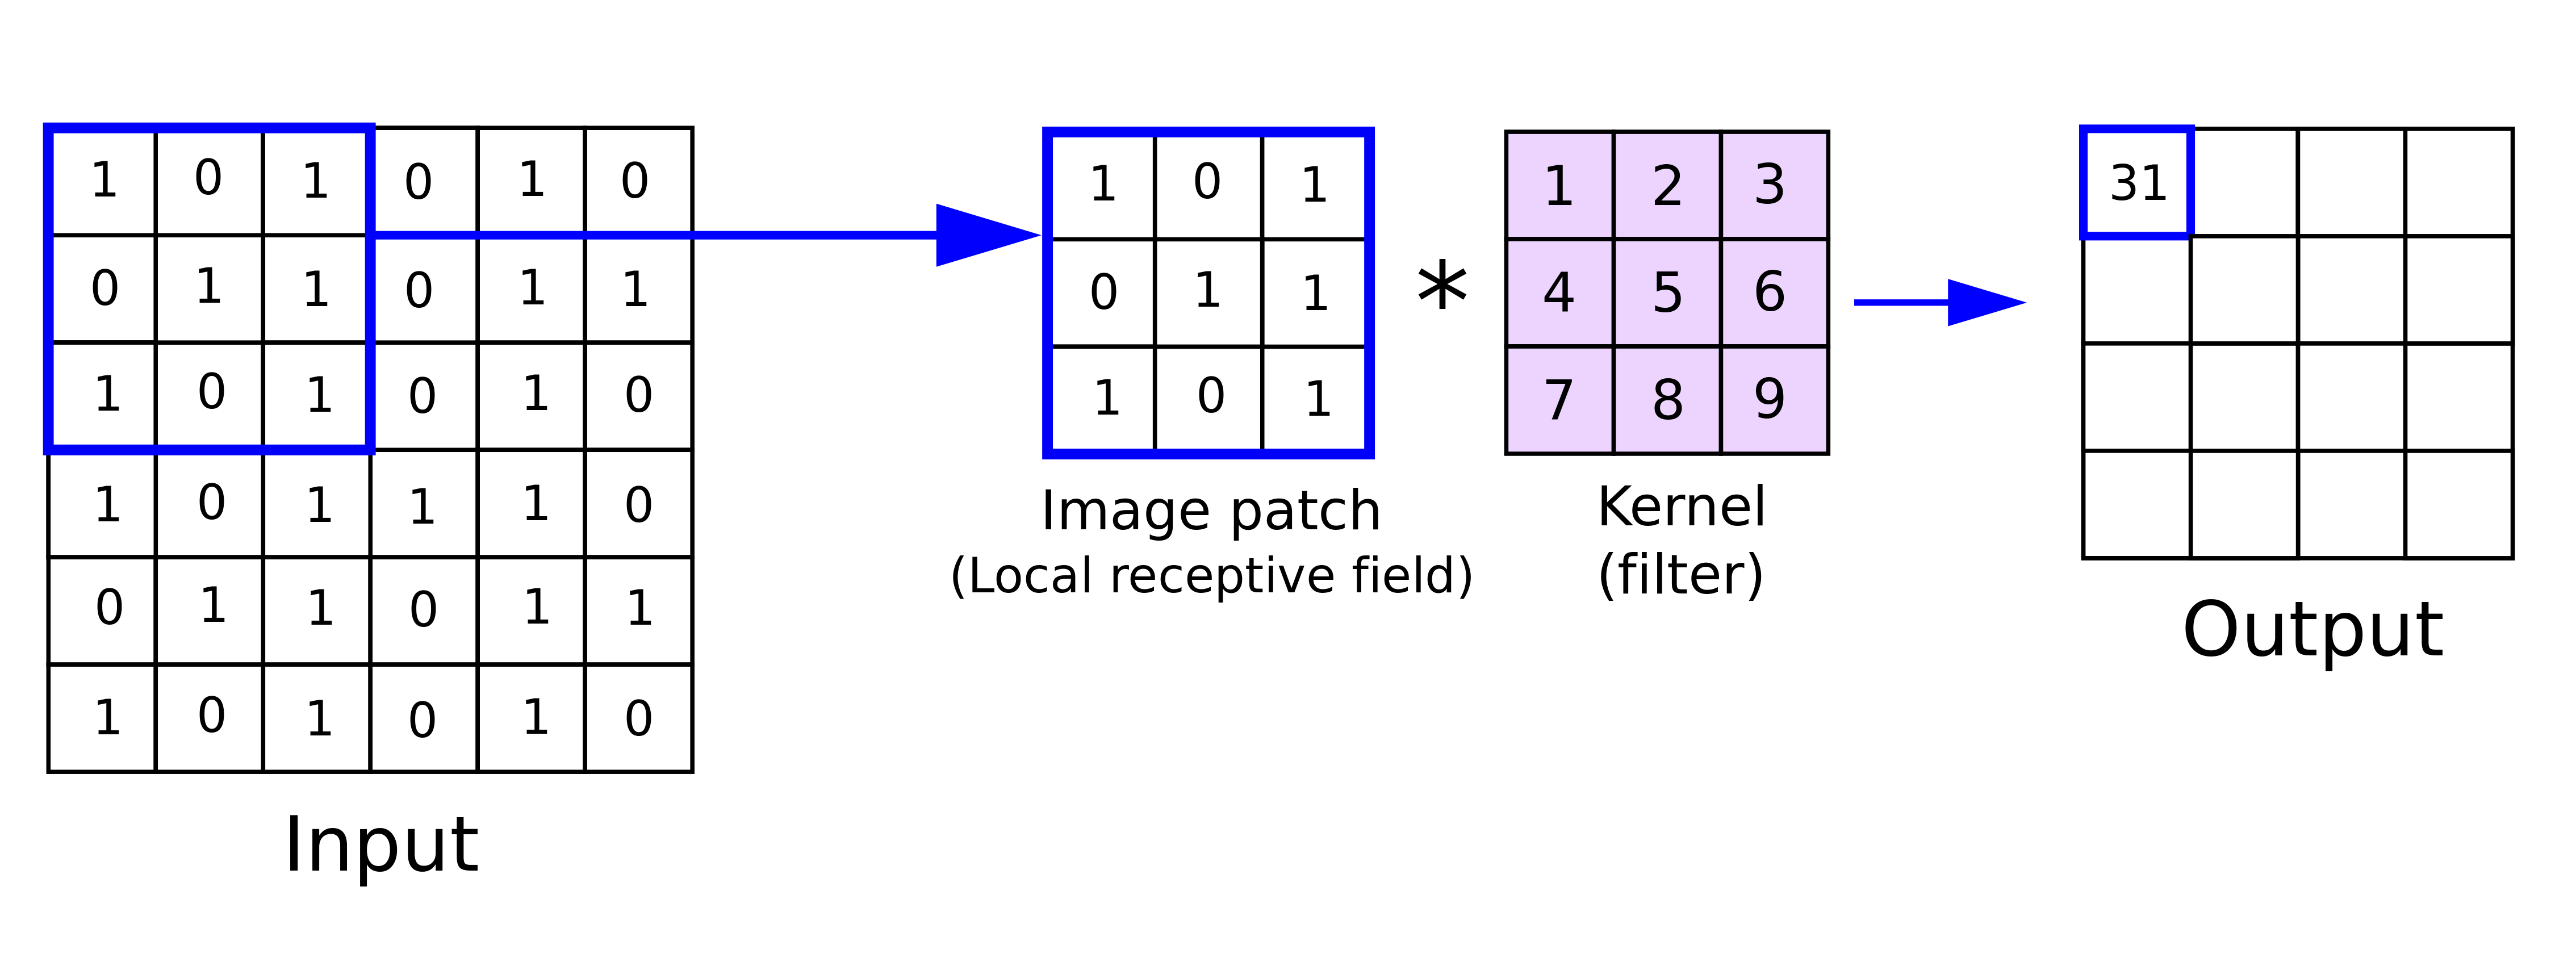

## Activation functions

An activation function is an important component of a neural network. A convolution is a linear operation. A stack of linear transformations results in, cumulatively, a linear transformation. For our network to learn non-linear relationships, we need to break this linearity. One of the most common actiation functions are Rectified Linear Units (ReLU). How the ReLU function works is simple, for each cell in the output feature map, any values below zero are replaced with zero. That's it!

An obvious question might by, why use such an arbitrary seeming non-lineary transformation? Computationally, ReLU is very inexpensiove. Other traditional transformations, such as a sigmoid or a hyperbolic tangent are costly to compute.

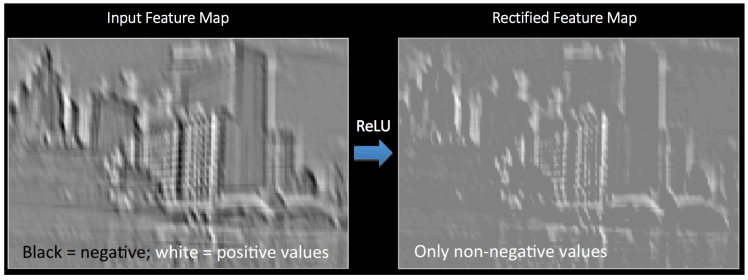

## Batch Normalization

Batch normalization is a key opperation in neural networks these days. Batch normalization takes the ouput feature maps and then re-scales their values so that the maps have 0 mean and unit variance. This makes updates much smoother and speeds convergence.

In the original Batch Normalization paper, users were advised to place the BatchNorm layer after the convolution and before the activation function. However, in practice, this is typically no longer done. You get better performace with the order: Conv, Activation, Batch Norm

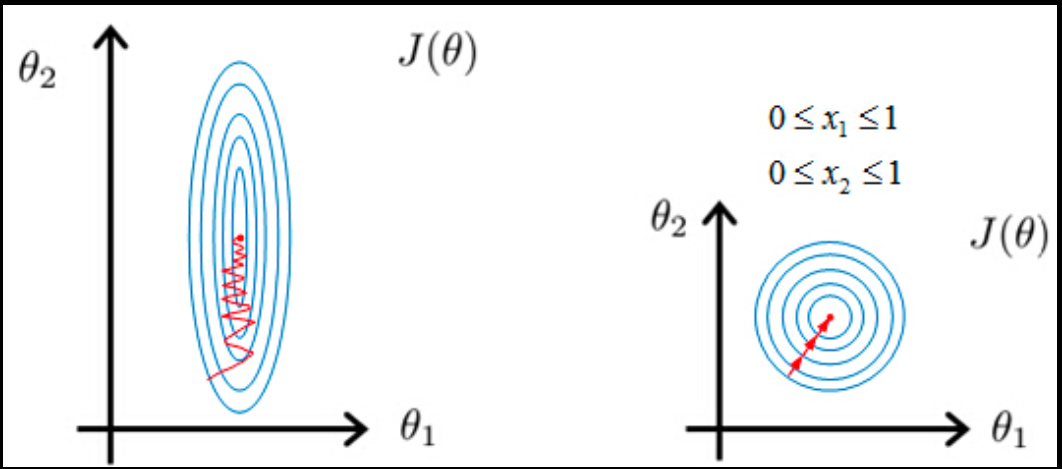

## Max Pooling

Max pooling is another important opperation. Periodically, we will downsample our feature maps. During this downsampling operation, we select the values in the feature map with the greatest values as these represent the most informative features (i.e., they produced the greatest response from a given filter). This downsampling proceedure has the nice property that it gives the network invariance to translation (i.e., a small shift in the input doesn't matter). It also gives the network a particular *je ne sais quoi* -- that is, we have zero idea why it work so well theoretically. But it does so we use it a lot. The idea is simple, in each 2x2 region of the input, pick the largest value!

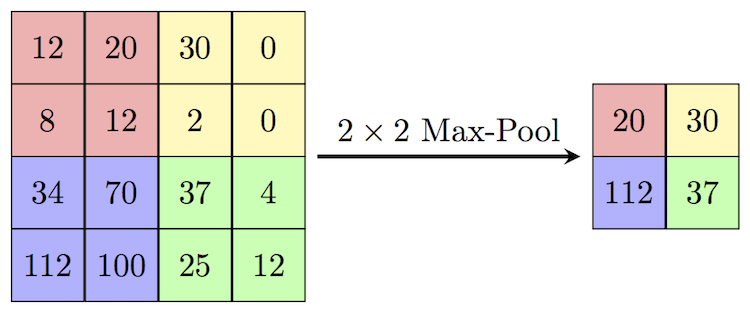


## Building a simple CNN

Here, we are going to build a 4-layer neural network!

### Convolutional Layers

In the network below, the 1st convolutional layer will extract 32 feature maps from the initial input. The 2nd convolutional layer will then extract 64 features from the output of the first layer. The 3nd convolutional layer will then extract 128 features from the output of the first layer.

### Output Layer

2D operations are a blast but eventually we need to turn our feature maps into a vector of features (also know as a list) from which we can perform our final classification. We do this with a global average pooling operation. From each of the 128 feature maps output by the 3rd convolutional layer, we compute the average.

Finally, the last layer in the network takes the flattened 128 features maps them to a vector of 10 values. Think of these 10 values as a histogram which reflects a probability distribution over all of the possible outputs (e.g., the digits 0-9). In a sense, these reflect the liklihood, according to our model, that input maps to a given output. To ensure this is a proper distribution, we apply the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to the output of the network. All this does is rescale the outputs of the network so that the 10-values sum to 1 like a proper distribution.

To perform our final classification, we simply take digit with the maximum value as our network's prediction. Voila!

In [ ]:
class Simple_CNN (nn.Module):

    def __init__(self):
        super(Simple_CNN, self).__init__()

        # Define the layers with learnable weights
        ### 1st layer: 33x33 --> 16x16
        self.conv1 = nn.Conv2d(in_channels=7, out_channels=32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32, affine=True)

        # 2rd layer: 16x16 --> 8x8
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64, affine=True)

        # 5rd layer: 8x8 --> 8x8
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128, affine=True)

        self.output = nn.Linear(in_features=128, out_features=1)

        # Define the other layers
        ### ReLU activation functions -- no learnable parameters so it
        ### can be reused multiple times
        self.relu = nn.ReLU()

        ### 2-dimensional max pooling. It will selected the largest value
        ### in each 2x2 neighborhood
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        ### Here, global varage pooling is used to distill the final 3x3
        ### activation maps into a feature vector (nx3x3 --> n)
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flat = nn.Flatten()

        return None

    def forward(self, x):
        x = self.pool(self.bn1(self.relu(self.conv1(x))))
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        x = self.pool(self.bn3(self.relu(self.conv3(x))))
        x = self.flat(self.global_pool(x))
        x = self.relu(self.output(x))
        return x

# Load in the model
model = Simple_CNN()

# Move the model to the proper device
model = model.to(DEVICE)


## Summarizing the neural network architecture

A summary of the neural network's layers can be printed out using the `summary(model, shape, device)`. We specify three inputs to the function, a PyTorch model, the shape of an input batch to the network, and the device to run everything on.

Note that in our example here, we specify a 4-dimensional input. This is because almost all neural networks use some variant of mini-batch stochastic gradient descent wherein groups of inputs are feed into the model.

Therefore, our model inputs will have the the following shape: *Batch x Channels x Rows x Columns*. Here, we feed in a single input to illistrate how the shape and number of parameters changes for each layer. Note that the output shape shrinks, with regards to the number of rows and columns, following the max pooling operations.

In [ ]:
# Print out a summary of the model
summary(model, (1,7,33,33), device=DEVICE)

## Defining the Residual Block

A Residual Convolutional Neural Network Block, commonly referred to as a Residual Block, is a fundamental component of Residual Networks (ResNets), a type of Convolutional Neural Network (CNN) architecture. This structure was introduced in the influential paper "Deep Residual Learning for Image Recognition" by Kaiming He et al., with the intent of enabling the training of much deeper networks.

A Residual Block comprises two primary components:

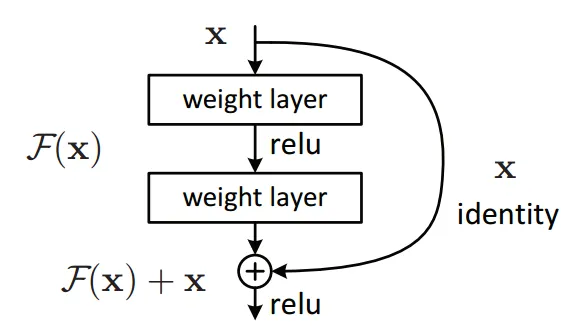

1. The main path, which contains the convolutional layers.

2. The identity (or skip connection), which is a direct path from the input to the output of the block.

The main path typically contains two or three convolutional layers, depending on the specific type of ResNet. These convolutional layers can have batch normalization applied to them and use a Rectified Linear Unit (ReLU) as the activation function. The purpose of these convolutional layers is to learn the residual function, or the difference between the input and output of the block.

The shortcut, on the other hand, is a direct path that allows the input to the block to bypass the main path and be added directly to the output of the main path. This skip connection enables the backpropagation signal to propagate deeper into the network and also helps to mitigate the issue of vanishing gradients.

If the dimensions of the input and the output of the main path do not match, then the shortcut path will include a 1x1 convolutional layer to transform the input to the appropriate dimensions. This transformation can be a simple identity function if the dimensions already match, or it could involve changing the number of channels or the height and width of the feature maps.

In [ ]:
class ResidualBlock (nn.Module):
    """
    A module representing a residual block in a ResNet.

    Each ResidualBlock consists of two Convolutional layers with a skip connection or
    shortcut adding the input of the block to the output.

    """
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes the ResidualBlock.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int, optional): Stride size for the convolutional layer. Defaults to 1.

        """
        super(ResidualBlock, self).__init__()

        # The residual block consists of 2 convolutional layers with kernel size 3.
        # Padding is 1 to preserve the spatial dimensions of the feature map.
        # Batch normalization is applied after each convolutional layer.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define the shortcut. This is used when the input and output are of different dimensions.
        # We use a 1x1 convolution to change the number of channels.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        return None

    def forward(self, x):
        """
        Defines the forward pass for the residual block.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.

        """
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # add the shortcut
        out = self.relu(out)
        return out

## Defining the Residual CNN

We will use the `ResidualBlock` to develop a Residual CNN. Typically, these will converge much more easily than a a simple stack of convolutional layers.

In [ ]:
class FlattenModule(nn.Module):
    def forward(self, input_tensor):
        return input_tensor.view(input_tensor.shape[0], input_tensor.shape[1])

class Residual_CNN (nn.Module):

    def __init__(self):
        super(Residual_CNN, self).__init__()

        # Input head using a 7x7 kernel
        self.input_layer = nn.Sequential(
            # Input Layers
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=7, padding=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16, affine=True)
            )

        # Residual Blocks 1 -- 33x33 --> 17x17
        self.layer_1 = nn.Sequential(
            ResidualBlock(16, 16),
            ResidualBlock(16, 32, stride=2),
        )

        # Residual Blocks 2 -- 17x17 --> 9x9
        self.layer_2 = nn.Sequential(
            ResidualBlock(32, 32),
            ResidualBlock(32, 64, stride=2),
        )

        # Residual Blocks 3 -- 9x9 --> 5x5
        self.layer_3 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64, stride=2),
        )

        # Define the output layer
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            # Input Layers
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32, affine=True),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, padding=0, bias=False),
            nn.ReLU(),
            FlattenModule()
            )

        return None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.output(x)
        return x

# Load in the model
model = Residual_CNN()

# Move the model to the proper device
model = model.to(DEVICE)

In [ ]:
summary(model, (1,7,33,33), device=DEVICE)

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# Training a CNN

## Defining a loss functions

Alright, we've made a neural network. Now we need to train it. How do we do that?

First, we need to define a loss function. When we score a network's prediction, we need to assess how bad the prediction was. Logically, if the network does very well on an example, we shouldn't need to adjust the weights much. If the network does horribly, we need to make a much bigger update.

Here, we are going to use [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_Squared_Error).

In [ ]:
loss_function = nn.MSELoss()

## Backpropagation algorithm

So, we have a neural network with a lot of parameters and a way to score the performance. How do we actually change the weights of the neural network to make it better. Enter Backpropagation!

Backpropagation is tricky to explain so I will give a very handwavy examplination and link a much better explaination for those that are curious.

## Calculus incoming

As you may remember, the chain-rule in calculus will allow you to compute the derivative of nested functions. Our neural network is simply a series of nested function! Lets say the first CNN layer is called $A$, our second layer is called $B$, the third layer is called $C$, the last layer is called $D$, the we will denote the ReLU function as $ReLU$, the softmax as $Softmax$, and lastly the loss function will be called $CE$.

Therefore, the loss of a given example of our neural network can be expressed as:

$f(x) = CE(Softmax(D(ReLU(C(ReLU(B(ReLU(A(x)))))))))$

The backpropagation algorithm uses the chain rule of calculus to compute the gradient of this loss function with respect to each of the parameters in the network.


## Why bother?

What is a gradient? Well, it tells you the direction with the greatest slope with respect to all of the  given parameter of a function. The slope of what? The loss function! What is our goal, to make the loss as small as possible!

As such, if we nudged every parameter in the network in a positive or negative direction according to the gradient produced by backpropagation, we would slightly reduce the error for that given example. Do that enough times with enough examples and the weights of th network will gradually converge!

## An example in 2 dimensions

Let's say we have a neural network with just 2 parameters, We can nicely represent the loss surface (i.e., the error of the network with respect to any combination of parameters) as a surface in 3D space. The X and Y axis are the possible parameter values and Z is the loss associated with a given combination. Our goal is to mountianeer our way down to the lowest possible error.

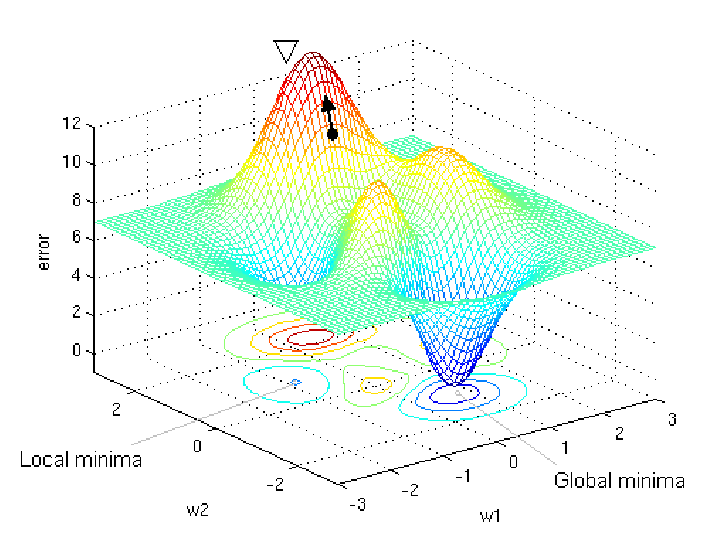




## Select an optimizer

The final component we need an the optimizer. The simplest optimizer is Stochastic Gradient Descent (SGD). With SGD, we take the raw gradient values produced by the backpropagation algorithm and scale them by a constant called the learning rate (typically a value between 1e-2 and 1e-5).

Here, we will use the ADAM optimizer. Adam is a more advanced version of SGD which is typically the default application in many situations.

Often, you will see literature that indicate that SGD will typically yeild greater performance than optimizers like ADAM, RMSProp, etc.

However, SGD is very finicky and can be be easily messed up by poor random initailization of the network weights, bad inputs which cause large gradients. Unless you need a extreme level of performance (i.e., winning benchmarks) you should probably just use ADAM.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Anatomy of a training loop

Now, we will actually train our neural network! Let's break this down textually.

We are going to loop over the training dataset a total of 10 times. Each loop over the entire training dataset is called an "epoch". Inside each each epoch, we will randomly shuffle the dataset (the data loader does this automatically so it isn't shown in the code) and then grab examples in sets of 8 (our batch size). We will feed these through the network and compute the loss. We will then backpropagate through the network to compute the gradients and then update the weights of the network with the optimizer!

In [ ]:
# Define the number of times to loop over the training dataset
num_epochs = 50

# Set the model to training model
model.train()

# Train the neural network for the specified number of epochs
for epoch in range(num_epochs):

    print(f"Training epoch {epoch+1} of {num_epochs}")

    # Loop over the dataset
    for x, y in tqdm(train_loader, mininterval=2):

        # Reset any previous computed gradients stored in the optimizer
        optimizer.zero_grad()

        # Compute the forward pass through the network
        y_hat = model(x.to(DEVICE))

        # Calculate the loss for the current batch
        loss = loss_function(y_hat, y.to(DEVICE))

        # Use Backpropagation to compute the gradients w.r.t. each parameter
        loss.backward()

        # Update the parameters
        optimizer.step()





## Evaluating the model

Our CNN model now is now trained. How good is it?

Let's feed every example in the testing set through the network and compute some scores.

In [ ]:
def print_error_statistics(input_model, input_loader):

    mse_outs = []
    mae_outs = []
    rmse_outs = []
    response_values = []
    preds = []

    print("Processing the testing dataset...")
    for x, y in tqdm(input_loader, mininterval=1):
        with torch.no_grad():
            y_hat = input_model(x.to(DEVICE)).squeeze(-1)
            y = y.to(DEVICE).squeeze(-1)

            y_hat_scaled = y_hat * 1000
            y_scaled = y * 1000

            mse = torch.mean((y_hat_scaled - y_scaled) ** 2)
            mae = torch.mean(torch.abs(y_hat_scaled - y_scaled))
            rmse = torch.sqrt(mse)

            mse_outs.append(mse)
            mae_outs.append(mae)
            rmse_outs.append(rmse)
            response_values.append(y_scaled)
            preds.append(y_hat_scaled)

    print("...Done.\n")

    # Flatten all values for R2 computation
    y_true = torch.cat(response_values, 0)
    y_pred = torch.cat(preds, 0)

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot

    test_mse = round(torch.stack(mse_outs).mean().cpu().item(), 3)
    test_mae = round(torch.stack(mae_outs).mean().cpu().item(), 3)
    test_rmse = round(torch.stack(rmse_outs).mean().cpu().item(), 3)
    response_mean = round(y_true.mean().cpu().item(), 3)
    test_n_rmse = round((test_rmse / response_mean) * 100, 3)
    r2_value = round(r2.cpu().item(), 4)

    print(f"Overall Mean Absolute Error         : {test_mae}")
    print(f"Overall Root Mean Squared Error     : {test_rmse}")
    print(f"Overall Root Mean Squared Error (%) : {test_n_rmse}")
    print(f"Overall R^2                         : {r2_value}")

    return None


In [ ]:
# Compute the test set error statistics
print_error_statistics (model, test_loader)

## Saving the model weights

After a model is trained, we want to be able to save the weights. This will allow us to reload the model later and perform inference.

Here, we will use the `torch.save()` function to save the model weights to our Google Drive folder (instead of the ephemeral storage in Colab). We will also use the torch.nn.Module method `.state_dict()` to get the weights from our network

In [ ]:
torch.save(model.state_dict(), f'{drive_dir}/network_weights.pth')

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# Performing inference using the neural network

Now that we have trained a neural network, we would like to use it to perform inference on unseen data. In the case, we have a small subset of Oregon overwhich we will make predictions

## Read in the Raster dataset

First, we are going to read in the raster dataset as a NumPy array

In [ ]:
# Open the dataset
ds = gdal.Open(f"{colab_dir}/oregon_subset_2022.tif")

# Get the raster data
raster_data = ds.ReadAsArray()

## Visualize the input

In [ ]:
def render_image(array3D, channels, min_values, max_values, ax=None, index=None):

    # Validate the inputs
    if len(channels) != 3 or len(min_values) != 3 or len(max_values) != 3:
        raise ValueError('Input lists must have exactly 3 elements.')

    # Extract the 3 channels
    extracted_channels = array3D[channels, :, :]

    # Clamp the values of each channel to the minimum and maximum value
    for i in range(3):
        extracted_channels[i, :, :] = np.clip(extracted_channels[i, :, :], min_values[i], max_values[i])

    # Linearly re-scale to 0-255 8-bit integers
    re_scaled_channels = np.zeros_like(extracted_channels, dtype=np.uint8)
    for i in range(3):
        re_scaled_channels[i, :, :] = np.interp(extracted_channels[i, :, :], (min_values[i], max_values[i]), (0, 255))

    # Reorder the axes for matplotlib
    img = np.transpose(re_scaled_channels, (1, 2, 0))

    # Render the image
    if ax is None:
      plt.imshow(img)
      plt.tight_layout()
      plt.axis('off')
      plt.show()
      return None
    else:
      ax[index].imshow(img)
      ax[index].axis('off')
      return

    return None

# Render the image
render_image(raster_data, [5,3,2], [0,0,0],[2000,5500,1500])

## Defining a helper dataset for inference

In [ ]:
class SceneDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, indices,feature_means, feature_stds):
        super(SceneDataset, self).__init__()
        self.dataset = dataset
        self.indices = indices
        self.feature_means = torch.Tensor(feature_means).view(7,1,1)
        self.feature_stds = torch.Tensor(feature_means).view(7,1,1)
        return None

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):

        # Get the features coordinates w.r.t. the raster domain
        i, j = self.indices[index]

        # Get the input feature maps
        feature = torch.Tensor(self.dataset[index]).float()

        # Cast the NumPy data as a Torch tensor an normalize
        feature = (feature - self.feature_means) / self.feature_stds

        return feature, (i, j)

## Function to visualize AGB maps

In [ ]:
def render_agb(agb_map, min_value, max_value, ax=None, index=None):

    # Clamp the values of the channel to the minimum and maximum value
    agb_map = np.clip(agb_map, min_value, max_value)

    # Linearly re-scale to 0-255 8-bit integers
    re_scaled_channel = np.interp(agb_map, (min_value, max_value), (0, 255)).astype(np.uint8)

    # Apply inverted viridis colormap
    cmap = plt.get_cmap('viridis')
    img = cmap(re_scaled_channel)

    # Render the image
    if ax is None:
      plt.imshow(img, cmap=cmap)
      plt.axis('off')
      plt.show()
      return None
    else:
      ax[index].imshow(img, cmap=cmap)
      ax[index].axis('off')
      return None

## Perform inference using the deep learning model

In [ ]:
# Get the shape of the input raster
N = raster_data.shape[1]
M = raster_data.shape[2]

# Initalize an output grid over the input raster
output_grid = np.full((N, M), -1).astype(np.int16)

# Define the input size (kernel size), the shard size (window_size)
# and padding
kernel_size = 33
window_size = 256

# Inference information
batch_size = 8192
num_workers = 2

# Padding factor based on the input
padding = (kernel_size // 2)

# Ensure the model is set to eval
model.eval()

# iterate over scene with stride = window_size
print('Beginning inference...')
for row_i, row in tqdm(enumerate(range(padding, N, window_size)), total=len(range(padding, N, window_size))):
    for col_i, col in enumerate(range(padding, M, window_size)):

        # Calculate subset scene with padding
        row_start = max(0, row - padding)
        row_end = min(N, row + window_size + padding)
        col_start = max(0, col - padding)
        col_end = min(M, col + window_size + padding)

        # extract window and apply padding if necessary
        window = raster_data[:, row_start:row_end, col_start:col_end]
        C, N_w, M_w = window.shape

        # Continue if we drew a slice smaller than the input size
        if N_w < kernel_size or M_w < kernel_size:
            continue

        # Using a sliding window to extract all inputs from the subset
        arrays = np.lib.stride_tricks.sliding_window_view(window[:7], (7,33,33))
        a_shp = arrays.shape
        arrays = arrays.reshape((a_shp[0] * a_shp[1] * a_shp[2], a_shp[3], a_shp[4], a_shp[5]))

        # Get the coordinates (w.r.t. the window)
        coordinates = []
        for i in range(kernel_size // 2, N_w - kernel_size // 2):
            for j in range(kernel_size // 2, M_w - kernel_size // 2):
                coordinates.append( (i,j) )

        # Clear memory
        window = None

        # Skip any windows with no valid locations
        if len(coordinates) == 0:
            continue

        # Disable gradient tracking because we don't need it for inference
        with torch.no_grad():

            # Create DataLoader for the subset of inputs
            dataset = SceneDataset(arrays, coordinates, feature_means, feature_stds)
            dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

            # Clear memory
            arrays = None
            coordinates = None

            # Loop over the different batches of the dataset
            for batch, indices in dataloader:

                # Compute the output
                with torch.cuda.amp.autocast():
                    batch_output = model(batch.to(DEVICE)).cpu().numpy() * 1000

                # Append to the initialize matrix covering the domain
                for output, i, j in zip(batch_output, indices[0], indices[1]):
                    output_grid[row+i - padding, col+j - padding] = output

        # This is just to help visualize what is happening
        render_agb(output_grid, 0, 500)

# Clean up memory
landsat = None
elevation = None
batch_output = None
batch = None
indices = None
dataset = None
dataloader = None

print('...done!')

## Visualize the AGB predictions

We will visualize the input dataset on the left and then render the prediction raster on the right.

In [ ]:
fig, ax = plt.subplots(1, 2)
render_image(raster_data, [5,3,2], [0,0,0],[2000,5500,1500], ax, 0)
render_agb(output_grid, 0, 500, ax, 1)

## Saving the predicted AGB data

Finally, we need to save the NumPy array containing the AGB estimates as a GeoTIFF that aligns with the original feature data.

Here, we define a helper function with takes acepts three inputs:


*   *feature_file*: The path to the GeoTIFF containing the feature data
*   *output_file*: The output file path where the file will be written
*    *numpy_array*: The output NumPy array which should align with the feature data's extent

The output AGB map will be written to your Google Drive folder.



In [ ]:
def numpy_to_geotiff(feature_file, output_file, numpy_array):

    # Open the input raster file and get its metadata
    src = gdal.Open(feature_file)
    src_band = src.GetRasterBand(1)

    # Ensure the provided numpy_array has the same shape as the source raster
    if numpy_array.shape != (src_band.YSize, src_band.XSize):
        raise ValueError("Provided NumPy array does not match the source raster shape.")

    # Create a driver for writing GeoTIFF files
    driver = gdal.GetDriverByName('GTiff')

    # Create the output raster file with the same metadata as the input file
    dst = driver.Create(output_file, src_band.XSize, src_band.YSize, 1, src_band.DataType)
    dst.SetGeoTransform(src.GetGeoTransform())
    dst.SetProjection(src.GetProjection())

    # Write the numpy array to the output raster file
    dst_band = dst.GetRasterBand(1)
    dst_band.WriteArray(numpy_array)

    # Properly close the datasets to flush to disk
    dst_band = None
    dst = None
    src_band = None
    src = None

    return None

numpy_to_geotiff(
    feature_file = f"{colab_dir}/oregon_subset_2022.tif",
    output_file = f"{drive_dir}/oregon_subset_2022_agb.tif",
    numpy_array = output_grid
    )

# =+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

# What sorts of features did the network learn?

Deep learning models are very much blackboxes for the moment. But, a neat way to try and understand what a network is doing is to visualize the activations produced by each layer. Then, we can see what sorts of features the model is picking up on in the image.

What I'm doing below is placing a "hook" into the layers of the network so we can pull out the intermediate activations. This will alow you to visualize the activation maps produced by each layer for a given example.

## Get a single example that we will examine

In [ ]:
def plot_images (input_image, single_channel_image, bands_to_select, min_max_values):

    # Create an RGB image using selected bands
    rgb_image = np.empty((3, input_image.shape[1], input_image.shape[2]), dtype=input_image.dtype)
    for i, band in enumerate(bands_to_select):
        # Stretch and rescale the band to fit within the provided range
        min_val, max_val = min_max_values[i]
        rgb_image[i] = np.clip(input_image[band], min_val, max_val)
        rgb_image[i] = (rgb_image[i] - min_val) / (max_val - min_val) * 255

    # Stretch the single channel image to fit within the 0-255 range using percentiles
    single_channel_percentiles = np.percentile(single_channel_image, (2, 98))
    single_channel_scaled = np.clip(single_channel_image, single_channel_percentiles[0], single_channel_percentiles[1])
    single_channel_scaled = (single_channel_scaled - single_channel_percentiles[0]) / (single_channel_percentiles[1] - single_channel_percentiles[0])
    single_channel_scaled *= 255

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the RGB image
    rgb_image_to_show = np.transpose(rgb_image, (1, 2, 0))
    axes[0].imshow(rgb_image_to_show.astype(np.uint8))
    axes[0].set_title('RGB Visualization')

    # Plot the single channel image
    axes[1].imshow(single_channel_scaled, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title('Single Channel Visualization')

    # Remove the axis ticks and labels
    for ax in axes:
        ax.axis('off')

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()


# Grab the first example from the test set
vis_features, vis_response = train_dataset[0]
vis_features.unsqueeze_(0)
vis_response = str(vis_response.detach().item())

# Render the input
temp_features = (vis_features * torch.Tensor(feature_stds).view(1,7,1,1)) + torch.Tensor(feature_means).view(1,7,1,1)

plot_images(
    temp_features[0,0:6,:,:].detach().cpu().numpy(),
    temp_features[0,-1,:,:].detach().cpu().numpy(),
    [5,3,2],
    [(0,1750),(0,5500),(0,1500)]
    )


## Define a function which will render the activation maps

In [ ]:
def plot_channels(matrix, min_val, max_val):

    num_channels = matrix.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_channels)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(num_channels):
        row = i // grid_size
        col = i % grid_size

        channel = matrix[i]
        channel_rescaled = np.clip(channel, min_val, max_val)
        channel_rescaled = (channel_rescaled - min_val) / (max_val - min_val) * 255

        axes[row, col].imshow(channel_rescaled, cmap='viridis', vmin=0, vmax=255)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

    # Remove empty subplots
    if num_channels < grid_size ** 2:
        for i in range(num_channels, grid_size ** 2):
            row = i // grid_size
            col = i % grid_size
            fig.delaxes(axes[row, col])

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

## Visualize activation maps from the input layer of the network



In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

print(vis_features.shape)

# Compute the forward pass w/ the hook
model.input_layer.register_forward_hook(get_activation('input_layer'))
output = model(vis_features.to(DEVICE))
act = activation['input_layer'].squeeze(0).detach().cpu().numpy()

# Plot the activations
plot_channels(act, 0, 3)


## Visualize activation maps from the first block of residual layers


In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Compute the forward pass w/ the hook
model.layer_1.register_forward_hook(get_activation('layer_1'))
output = model(vis_features.to(DEVICE))
act = activation['layer_1'].squeeze(0).detach().cpu().numpy()

# Plot the activations
plot_channels(act, 0, 3)

## Visualize activation maps from the second block of residual layers





In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Compute the forward pass w/ the hook
model.layer_2.register_forward_hook(get_activation('layer_2'))
output = model(vis_features.to(DEVICE))
act = activation['layer_2'].squeeze(0).detach().cpu().numpy()

# Plot the activations
plot_channels(act, 0, 3)

## Visualize activation maps from the second block of residual layers


In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Compute the forward pass w/ the hook
model.layer_3.register_forward_hook(get_activation('layer_3'))
output = model(vis_features.to(DEVICE))
act = activation['layer_3'].squeeze(0).detach().cpu().numpy()

# Plot the activations
plot_channels(act, 0, 2)